In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,FunctionTransformer,StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit, train_test_split, learning_curve,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, roc_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
rnd_state = 0

In [3]:
# create a database connection
sqluser = 'maxim'
dbname = 'maxim'
schema_name = 'mimiciii'

In [4]:
# Connect to local postgres version of mimic
connect = psycopg2.connect(dbname=dbname, user=sqluser)
cursor = connect.cursor()
cursor.execute('SET search_path to {}'.format(schema_name))

In [64]:
# Load in the query from file
query='SELECT * FROM OASIS'
oasis = pd.read_sql_query(query, connect)
#oasis = oasis.dropna(axis=0)
#oasis = oasis.loc[(oasis.icustay_age_group == 'adult')]
#oasis = oasis.loc[(oasis.urineoutput < 20000) & (oasis.urineoutput > 0) & 
#                  (oasis.temp > 30) & (oasis.temp < 45) & ]
#oasis.loc[oasis.age > 299,'age'] = 90
oasis.loc[oasis.urineoutput > 10000,'urineoutput'] = 10000
oasis.loc[oasis.urineoutput < 0,'urineoutput'] = np.nan
oasis.loc[oasis.temp < 32,'temp'] = np.nan
oasis.loc[oasis.temp > 42,'temp'] = 42
oasis['preiculos_hours'] = oasis.preiculos.dt.total_seconds()/3600
oasis.loc[oasis.preiculos_hours > 24*14,'preiculos_hours'] = 24*14

In [65]:
oasis.head()

,subject_id,hadm_id,icustay_id,icustay_age_group,hospital_expire_flag,icustay_expire_flag,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heartrate_score,meanbp,meanbp_score,resprate,resprate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score,preiculos_hours
0,55973,152234,200001,adult,0,0,42,0.305849,61.0,6,7 days 03:02:12,1,14.0,3.0,134.0,6.0,60.000000,2.0,32.0,6.0,36.388889,2.0,250.0,10.0,0,0,0,6,171.036667
1,27513,163557,200003,adult,0,0,35,0.152892,48.0,3,0 days 02:48:04,3,15.0,0.0,122.0,3.0,179.000000,3.0,39.0,6.0,36.388889,2.0,3652.0,0.0,1,9,0,6,2.801111
2,10950,189514,200006,adult,0,0,32,0.109623,54.0,6,0 days 00:01:14,5,15.0,0.0,73.0,0.0,61.000000,2.0,27.0,1.0,36.166666,2.0,1955.0,1.0,1,9,0,6,0.020556
3,20707,129310,200007,adult,0,0,26,0.054187,43.0,3,0 days 00:01:37,5,15.0,0.0,104.0,1.0,50.666698,3.0,29.0,1.0,36.388889,2.0,1295.0,5.0,0,0,0,6,0.026944
4,29904,129607,200009,adult,0,0,25,0.048012,47.0,3,-1 days +23:49:32,5,15.0,0.0,106.0,1.0,60.000000,2.0,17.5,0.0,34.599998,4.0,1570.0,1.0,1,9,1,0,-0.174444


In [66]:
oasis.describe()

,subject_id,hadm_id,icustay_id,hospital_expire_flag,icustay_expire_flag,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heartrate_score,meanbp,meanbp_score,resprate,resprate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score,preiculos_hours
count,61532.000000,61532.000000,61532.000000,61532.000000,61532.000000,61532.000000,61532.000000,61532.000000,61532.000000,61532,61532.000000,52143.000000,52143.000000,59048.000000,59048.000000,52288.000000,52288.000000,52229.000000,52229.000000,51298.000000,51382.000000,53189.000000,53201.000000,61532.000000,61532.000000,61532.000000,61532.000000,61532.000000
mean,33888.605912,149954.470649,249962.710248,0.107408,0.075099,29.650182,0.130882,64.470552,4.997741,1 days 18:13:47.066810,3.249642,13.744664,1.612891,107.315851,2.451717,68.853043,1.542304,24.687757,2.466446,36.475188,2.714161,1802.785696,3.526005,0.400946,3.608513,0.107408,5.355555,32.573389
std,28127.690913,28898.895904,28890.574867,0.309633,0.263553,9.811318,0.138891,56.913254,2.820875,5 days 23:21:40.469343,1.928835,2.615417,2.539539,29.645415,2.227894,30.915013,1.260073,9.816155,2.661418,1.210165,1.057916,1329.219672,3.663245,0.490094,4.410846,0.309633,1.857799,74.735980
min,2.000000,100001.000000,200001.000000,0.000000,0.000000,0.000000,0.002077,0.000000,0.000000,-2 days +12:14:05,0.000000,3.000000,0.000000,0.350000,0.000000,0.200000,0.000000,0.200000,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-35.765278
25%,12047.500000,124933.750000,224935.500000,0.000000,0.000000,23.000000,0.037612,44.000000,3.000000,0 days 00:01:25,1.000000,14.000000,0.000000,90.000000,1.000000,51.000000,0.000000,19.000000,1.000000,35.666667,2.000000,876.000000,1.000000,0.000000,0.000000,0.000000,6.000000,0.023611
50%,24280.500000,149911.500000,249940.000000,0.000000,0.000000,29.000000,0.077479,62.000000,6.000000,0 days 00:10:30.500000,3.000000,15.000000,0.000000,105.000000,1.000000,59.000000,2.000000,26.000000,1.000000,36.111111,2.000000,1582.000000,1.000000,0.000000,0.000000,0.000000,6.000000,0.175139
75%,54191.500000,174997.250000,274972.500000,0.000000,0.000000,36.000000,0.170145,76.000000,6.000000,0 days 19:13:45.250000,5.000000,15.000000,3.000000,124.000000,3.000000,85.500000,3.000000,30.000000,6.000000,37.388889,4.000000,2470.000000,5.000000,1.000000,9.000000,0.000000,6.000000,19.229236
max,99999.000000,199999.000000,299999.000000,1.000000,1.000000,70.000000,0.939936,311.000000,9.000000,200 days 16:35:54,5.000000,15.000000,10.000000,286.000000,6.000000,299.000000,4.000000,69.000000,10.000000,42.000000,6.000000,10000.000000,10.000000,1.000000,9.000000,1.000000,6.000000,336.000000


In [67]:
oasis.shape

(61532, 29)

Text(0.5, 0, 'Age')

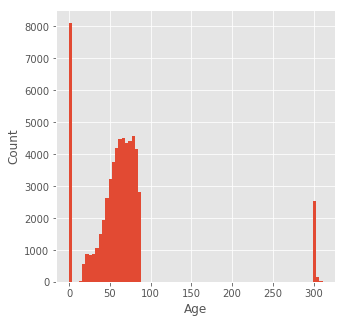

In [68]:
oasis.age.hist(bins=77,figsize=(5,5))
plt.ylabel('Count')
plt.xlabel('Age')

In [69]:
oasis.loc[oasis.age > 299,'age'] = 89
oasis = oasis.loc[(oasis.icustay_age_group == 'adult')]

Text(0.5, 0, 'Age')

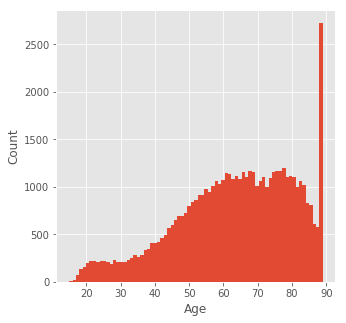

In [71]:
oasis.age.hist(bins=75,figsize=(5,5))
plt.ylabel('Count')
plt.xlabel('Age')

Text(0.5, 0, 'Age')

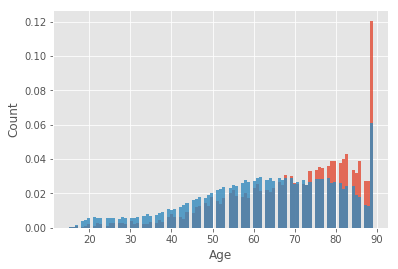

In [88]:
plt.hist(oasis.loc[oasis.hospital_expire_flag == 1].age,density=1,alpha=0.8,bins=99)
plt.hist(oasis.loc[oasis.hospital_expire_flag == 0].age,density=1,alpha=0.8,bins=99)
plt.ylabel('Count')
plt.xlabel('Age')

(array([32926.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  9026.,     0.,     0.,     0.,     0.,     0.,     0.,
         2762.,     0.,     0.,     0.,     0.,  1053.,     0.,     0.,
            0.,   994.,     0.,     0.,  1120.,     0.,   828.,     0.,
            0.,   723.,   626.,     0.,   466.,   149.,   178.,  1291.]),
 array([-0.2       , -0.19647059, -0.19294118, -0.18941176, -0.18588235,
        -0.18235294, -0.17882353, -0.17529412, -0.17176471, -0.16823529,
        -0.16470588, -0.16117647, -0.15764706, -0.15411765, -0.15058824,
        -0.14705882, -0.14352941, -0.14      , -0.13647059, -0.13294118,
        -0.12941176, -0.12588235, -0.12235294, -0.11882353, -0.11529412,
        -0.11176471, -0.10823529, -0.10470588, -0.10117647, -0.09764706,
        -0.09411765, -0.09058824, -0.08705882, -0.08352941, -0.08      ,
        -0.07647059, -0.07294118, -0.06941176, -0.06588235, -0.06235294,
        -0.05882353]),
 <a list of 40 Patch objects>)

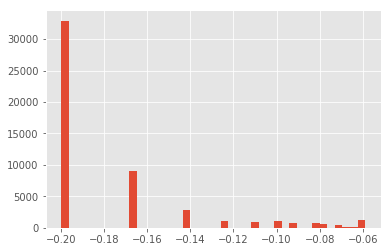

In [232]:
plt.hist(1./(oasis.gcs-20),bins=40)

(array([ 1291.,     0.,     0.,   178.,     0.,     0.,   149.,     0.,
            0.,     0.,   466.,     0.,     0.,   626.,     0.,     0.,
          723.,     0.,     0.,     0.,   828.,     0.,     0.,  1120.,
            0.,     0.,   994.,     0.,     0.,     0.,  1053.,     0.,
            0.,  2762.,     0.,     0.,  9026.,     0.,     0., 32926.]),
 array([ 3. ,  3.3,  3.6,  3.9,  4.2,  4.5,  4.8,  5.1,  5.4,  5.7,  6. ,
         6.3,  6.6,  6.9,  7.2,  7.5,  7.8,  8.1,  8.4,  8.7,  9. ,  9.3,
         9.6,  9.9, 10.2, 10.5, 10.8, 11.1, 11.4, 11.7, 12. , 12.3, 12.6,
        12.9, 13.2, 13.5, 13.8, 14.1, 14.4, 14.7, 15. ]),
 <a list of 40 Patch objects>)

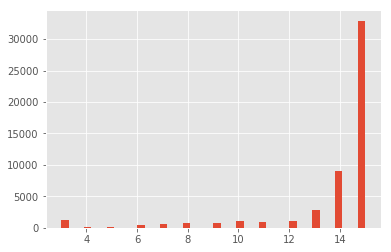

In [233]:
plt.hist(oasis.gcs,bins=40)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a29d1c2e8>,
      dtype=object)

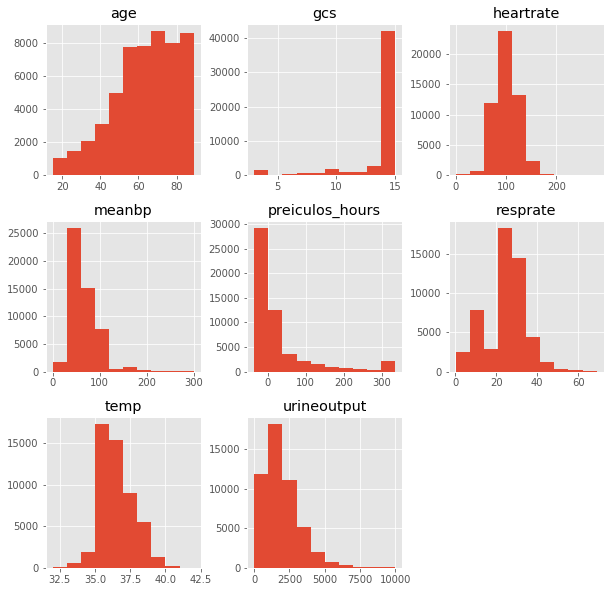

In [89]:

feats = ['age', 'preiculos_hours', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp', 'urineoutput']
oasis[feats].hist(figsize=(10,10))


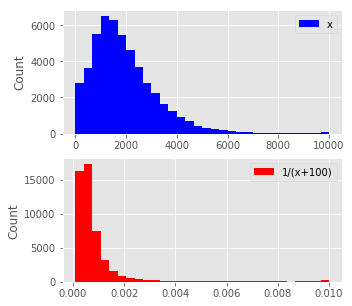

In [363]:
f, axs = plt.subplots(2,1,figsize=(5,5))

y = oasis.urineoutput.values
axs[0].hist(y,30,color='blue',label='x')
axs[0].legend(loc='upper right')
#axs[0].set_xlabel('Time, hours')
axs[0].set_ylabel('Count')
#axs[0].set_xlim(-100, 3600)
#axs[0].set_ylim(50, 220)

y = 1./(oasis.urineoutput.values+100)
axs[1].hist(y,30,color='red',label='1/(x+100)')
axs[1].legend(loc='upper right')
#axs[0].set_xlabel('Time, hours')
axs[1].set_ylabel('Count')
#axs[0].set_xlim(-100, 3600)
#axs[0].set_ylim(50, 220)

plt.savefig('urineoutput.pdf')

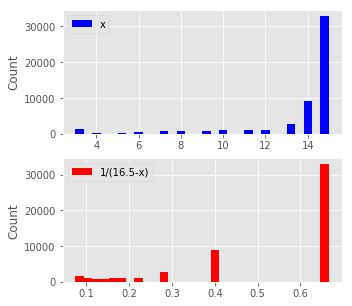

In [364]:
f, axs = plt.subplots(2,1,figsize=(5,5))

y = oasis.gcs.values
axs[0].hist(y,30,color='blue',label='x')
axs[0].legend(loc='upper left')
#axs[0].set_xlabel('Time, hours')
axs[0].set_ylabel('Count')
#axs[0].set_xlim(-100, 3600)
#axs[0].set_ylim(50, 220)

y = 1./(16.5-oasis.gcs.values)
axs[1].hist(y,30,color='red',label='1/(16.5-x)')
axs[1].legend(loc='upper left')
#axs[0].set_xlabel('Time, hours')
axs[1].set_ylabel('Count')
#axs[0].set_xlim(-100, 3600)
#axs[0].set_ylim(50, 220)

plt.savefig('gcs.pdf')

In [333]:
num_features = ['preiculos_hours','age', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp', 'urineoutput']
cat_features = ['mechvent', 'electivesurgery']

#X = oasis[num_features].multiply(oasis.meanbp,axis=0)
#X[cat_features + ['oasis_prob']] = oasis[cat_features+ ['oasis_prob']]

In [354]:
#X = oasis_adults.drop(['subject_id', 'hadm_id', 'icustay_id', 'icustay_age_group', 'hospital_expire_flag',
#                       'icustay_expire_flag', 'oasis', 'oasis_prob', 'age_prob'], axis=1)
X = oasis[num_features + cat_features + ['oasis_prob']]
X['new_feat'] = 1./(14.5-X['gcs'].values)
X['new_feat_2'] = 1./(X['urineoutput'].values+100)
#y = oasis.icustay_expire_flag
y = oasis.hospital_expire_flag
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, test_size=0.25, \
                                                    shuffle=True, stratify=y, random_state=rnd_state)
oasis_prob_test = X_test_orig['oasis_prob']
X_train_orig = X_train_orig.drop(['oasis_prob'],axis=1)
X_test_orig = X_test_orig.drop(['oasis_prob'],axis=1)

/Users/maxim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/maxim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [355]:
print('Shape of training set: {}'.format(X_train_orig.shape))
print('Shape of test set: {}'.format(X_test_orig.shape))
print('Number of positives in training set: {}'.format(y_train.sum()))
print('Number of positives in test set: {}'.format(y_test.sum()))

Shape of training set: (40073, 12)
Shape of test set: (13358, 12)
Number of positives in training set: 4909
Number of positives in test set: 1636


In [356]:
num_impute = ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
scale = ('scale', MinMaxScaler())
num_transformer = Pipeline([num_impute, scale])

cat_impute = ('cat_impute', SimpleImputer(strategy='constant', fill_value=2))
#onehot = ('onehot', OneHotEncoder(handle_unknown='error'))
cat_transformer = Pipeline(steps=[cat_impute])

preprocessor = ColumnTransformer(transformers=[
        ('num', num_transformer, num_features+['new_feat', 'new_feat_2']),
        ('cat', cat_transformer, cat_features)])

X_train = preprocessor.fit_transform(X_train_orig)
X_test = preprocessor.transform(X_test_orig)

In [357]:
lr = LogisticRegression(random_state=rnd_state,solver='lbfgs',max_iter=1000,class_weight='balanced',C=1.,tol=0.0001)

lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
F1 = f1_score(y_test, predictions)
auroc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
res = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
print(res)

TEST SET f1: 0.39 auroc: 0.80 precision: 0.27 recall: 0.71


In [ ]:
TEST SET f1: 0.39 auroc: 0.80 precision: 0.27 recall: 0.71

In [110]:
logit = np.dot(lr.coef_,X_test.T)
probabilities = np.exp(logit)/(1.+np.exp(logit))

(array([  1.,   1.,   0.,   1.,   1.,   0.,   2.,   2.,   4.,   4.,  10.,
         18.,  26.,  35.,  41.,  63.,  91., 106., 180., 204., 302., 357.,
        445., 525., 611., 720., 810., 856., 873., 882., 858., 815., 769.,
        706., 622., 530., 482., 360., 315., 203., 177., 129.,  67.,  59.,
         44.,  18.,  14.,  10.,   6.,   3.]),
 array([-5.23595785, -5.04430907, -4.85266028, -4.6610115 , -4.46936272,
        -4.27771393, -4.08606515, -3.89441637, -3.70276758, -3.5111188 ,
        -3.31947002, -3.12782123, -2.93617245, -2.74452367, -2.55287488,
        -2.3612261 , -2.16957732, -1.97792853, -1.78627975, -1.59463097,
        -1.40298218, -1.2113334 , -1.01968462, -0.82803583, -0.63638705,
        -0.44473827, -0.25308948, -0.0614407 ,  0.13020808,  0.32185687,
         0.51350565,  0.70515443,  0.89680321,  1.088452  ,  1.28010078,
         1.47174956,  1.66339835,  1.85504713,  2.04669591,  2.2383447 ,
         2.42999348,  2.62164226,  2.81329105,  3.00493983,  3.19658861,
 

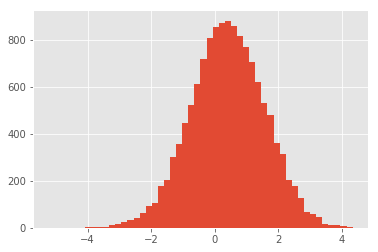

In [111]:
plt.hist(logit[0],bins=50)

(array([ 41., 124., 184., 239., 280., 323., 336., 375., 363., 410., 369.,
        427., 401., 432., 406., 405., 406., 395., 380., 368., 352., 392.,
        342., 366., 326., 320., 339., 304., 304., 302., 266., 293., 259.,
        259., 228., 244., 251., 207., 206., 189., 186., 142., 137., 131.,
        113.,  71.,  71.,  53.,  24.,  17.]),
 array([0.00225965, 0.02162374, 0.04098782, 0.0603519 , 0.07971598,
        0.09908007, 0.11844415, 0.13780823, 0.15717232, 0.1765364 ,
        0.19590048, 0.21526456, 0.23462865, 0.25399273, 0.27335681,
        0.2927209 , 0.31208498, 0.33144906, 0.35081314, 0.37017723,
        0.38954131, 0.40890539, 0.42826948, 0.44763356, 0.46699764,
        0.48636172, 0.50572581, 0.52508989, 0.54445397, 0.56381806,
        0.58318214, 0.60254622, 0.6219103 , 0.64127439, 0.66063847,
        0.68000255, 0.69936664, 0.71873072, 0.7380948 , 0.75745888,
        0.77682297, 0.79618705, 0.81555113, 0.83491522, 0.8542793 ,
        0.87364338, 0.89300746, 0.91237155, 0.

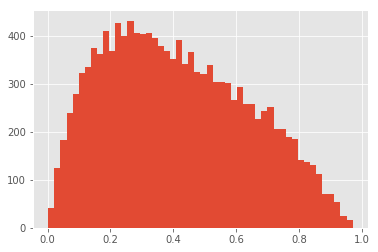

In [112]:
plt.hist(lr.predict_proba(X_test)[:, 1],bins=50)

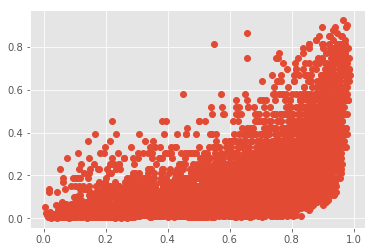

In [113]:
plt.plot(probabilities[0], oasis_prob_test, 'o')

(array([15283., 11518.,  8825.,  5476.,  2959.,  2460.,   988.,  1705.,
         1243.,   533.,   446.,   681.,   262.,   387.,   264.,   180.,
           95.,    57.,    53.,    16.]),
 array([0.00207731, 0.04897025, 0.09586318, 0.14275611, 0.18964904,
        0.23654197, 0.2834349 , 0.33032783, 0.37722076, 0.42411369,
        0.47100663, 0.51789956, 0.56479249, 0.61168542, 0.65857835,
        0.70547128, 0.75236421, 0.79925714, 0.84615007, 0.89304301,
        0.93993594]),
 <a list of 20 Patch objects>)

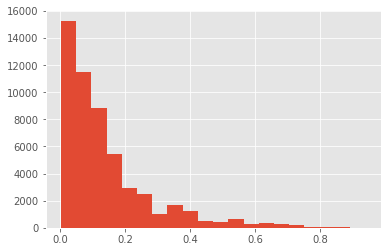

In [114]:
plt.hist(oasis.oasis_prob,bins=20)

In [115]:
auroc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
auroc

0.7899147591576494

In [116]:
auroc = roc_auc_score(y_test, oasis_prob_test)
auroc

0.7676826982803323

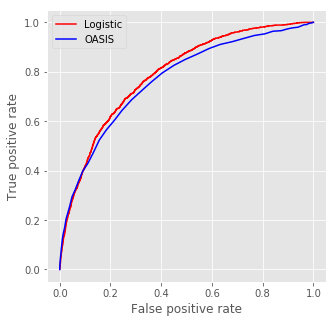

In [117]:
f, axs = plt.subplots(1,1,figsize=(5,5))

a,b,c = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
plt.plot(a,b,label='Logistic',color='red')
a,b,c = roc_curve(y_test, oasis_prob_test)
plt.plot(a,b,label='OASIS',color='blue')
plt.legend(loc='best')
axs.set_xlabel('False positive rate')
axs.set_ylabel('True positive rate')

plt.savefig('logistic_oasis.pdf')

In [118]:
gbc = GradientBoostingClassifier(random_state=rnd_state)


gbc.fit(X_train, y_train,sample_weight=compute_sample_weight(class_weight='balanced', y=y_train))
predictions = gbc.predict(X_test)
F1 = f1_score(y_test, predictions)
auroc = roc_auc_score(y_test, gbc.predict_proba(X_test)[:, 1])
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
res = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
print(name)
print(res)

Logistic
TEST SET f1: 0.44 auroc: 0.84 precision: 0.31 recall: 0.76


Text(0, 0.5, 'Feature Importance Score')

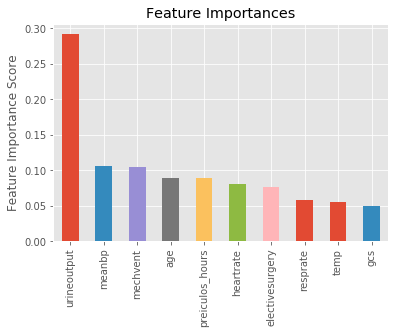

In [119]:
features = num_features + cat_features
feat_imp = pd.Series(gbc.feature_importances_, features).sort_values(ascending=False)
feat_imp.iloc[0:30].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [94]:
predictions.sum()

3004

In [93]:
oasis.icustay_expire_flag.value_counts()

0    44636
1     3861
Name: icustay_expire_flag, dtype: int64

In [37]:
oasis_predictions = oasis.oasis_prob.values
oasis_binary_predictions = oasis.oasis_prob.round().values
y_full = oasis.hospital_expire_flag.values
F1 = f1_score(y_full, oasis_binary_predictions)
auroc = roc_auc_score(y_full, oasis_predictions)
precision = precision_score(y_full, oasis_binary_predictions)
recall = recall_score(y_full, oasis_binary_predictions)
res = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
print(res)

TEST SET f1: 0.28 auroc: 0.79 precision: 0.55 recall: 0.18


In [108]:
auroc = roc_auc_score(y_full, oasis.oasis_prob.values)
auroc

0.7907149725755048

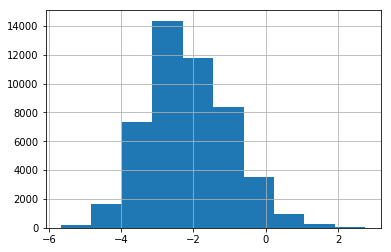

In [100]:
logit = -6.1746 + 0.1275 * oasis.oasis
logit.hist()

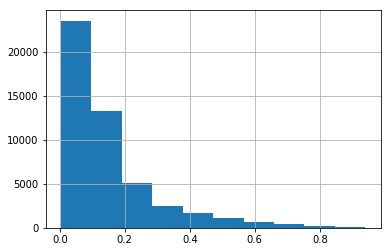

In [101]:
oasis.oasis_prob.hist()

In [92]:
oasis_predictions = np.random.randint(0,2,len(y_full))
oasis_predictions = [1]*len(y_full)
y_full = oasis.icustay_expire_flag.values
F1 = f1_score(y_full, oasis_predictions)
auroc = roc_auc_score(y_full, oasis_predictions)
precision = precision_score(y_full, oasis_predictions)
recall = recall_score(y_full, oasis_predictions)
res = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
print(res)

TEST SET f1: 0.15 auroc: 0.50 precision: 0.08 recall: 1.00
